In [1]:
"""
  A manager that facilitates reading and writing files to GCP Storage
"""
import logging
import os
import subprocess
from io import BytesIO
from typing import List, Dict, Callable, Tuple, Union
from mypy_extensions import TypedDict

from google.cloud import storage # type: ignore

def get_path_prefix(root_dir: str, relative_path: str) -> str:
    prefix = ''
    if root_dir:
        prefix = root_dir.rstrip('/') + '/'

    if relative_path and relative_path != '/':
        prefix = prefix + relative_path.strip('/') + '/'

    return prefix

class PathNode(TypedDict, total=False):
    name: str
    type: str
    size: float
        
class GCPStorageManager(object):

    def __init__(self, storage_details: Dict, verbose: bool) -> None:
        self._bucket_name = storage_details.get('bucket')
        self._root_dir = storage_details.get('root')
        self.client = storage.Client()
        self.verbose = verbose

    def _abs_path(self, rel_path: str) -> str:
        if not self._root_dir:
            return rel_path

        return os.path.join(self._root_dir, rel_path)

    def _build_current_url(self) -> str:
        if self._root_dir:
            return "https://console.cloud.google.com/storage/browser/" + self._bucket_name + "/" + self._root_dir
        else:
            return "https://console.cloud.google.com/storage/browser/" + self._bucket_name

    def get_root_dir(self) -> str:
        return self._root_dir

    def get_storage_details(self) -> Dict:
        return {
            'provider': file_utils.ProviderList.GCP_STORAGE,
            'bucket': self._bucket_name,
            'root': self._root_dir
        }

    def get_sync_login_command(self, env_vars: Dict) -> List[str]:
        return None

    def get_sync_url(self, path: str) -> str:
        if not path or path == '/':
            abs_path = self._root_dir
        else:
            abs_path = self._abs_path(path)
        return f'gs://{self._bucket_name}/{abs_path}'

    def get_sync_command(self, src_dir: str, remote_path: str) -> Callable:

        def sync_call() -> Tuple[int, str]:
            cmd = ['gsutil', 'rsync', '-r', src_dir, self.get_sync_url(remote_path)]
            p = subprocess.Popen(cmd, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
            stdout, stderr = p.communicate()
            err_code = 0
            stderr_val = ''

            if p.returncode != 0:
                logging.error('Copy response is: {}'.format(stderr.decode('utf-8')))
                stderr_val = stderr.decode('utf-8')
                err_code = p.returncode

            return err_code, stderr_val

        return sync_call

    def rm_file(self, relative_path: str) -> None:
        bucket = self.client.bucket(self._bucket_name)
        path = self._abs_path(relative_path)
        blob = bucket.blob(path)
        logging.info('Deleting file at ' + path)
        blob.delete()

    def rm_dir(self, relative_path: str) -> None:
        bucket = self.client.bucket(self._bucket_name)
        prefix = get_path_prefix(self._root_dir, relative_path)
        blob = bucket.blob(prefix)
        logging.info('Deleting files at ' + prefix)
        blob.delete()

    def read_content(self, path: str, throw_exception: bool, read_range: str = None, streaming: bool = False) -> bytes:
        try:
            path = self._abs_path(path)
            bucket = self.client.bucket(self._bucket_name)
            blob = bucket.blob(path)
            result = blob.download_as_bytes()

            if self.verbose:
                logging.info(f"Downloading content from {self._build_current_url()}/{path}")

            return result
        except Exception as e:
            raise

    #def gen_presigned_url(self, path: str) -> str:
    #    # dask and other frameworks explicit s3 link rather than a byte stream or contet (e.g. s3://bucket/foo.csv)
    #    return self._s3.generate_presigned_url('get_object',
    #                                           Params={'Bucket': self._bucket_name, 'Key': self._abs_path(path)})

    # Checks to see if the job directory exists.  No side-effects.
    def check_dir_exists(self, path: str) -> bool:
        # Create the prefix for this particular job.
        exists = False
        prefix = get_path_prefix(self._root_dir, path)
        blobs = list(self.client.list_blobs(
            self._bucket_name, prefix=prefix
        ))
        if len(blobs) > 0:
            exists = True

        return exists

    def _download_content(self, remote_path: str) -> bytes:
        remote_path = self._abs_path(remote_path)
        bucket = self.client.bucket(self._bucket_name)
        blob = bucket.blob(remote_path)
        if self.verbose:
            logging.info(f"Downloading content from {self._build_current_url()}/{remote_path}")

        fileobj = BytesIO()
        blob.download_to_file(fileobj)
        return fileobj.getvalue()

    def download_file(self, remote_path: str, file_name: str) -> None:
        # Move references to large data items across folders
        remote_path = self._abs_path(remote_path)
        bucket = self.client.bucket(self._bucket_name)
        blob = bucket.blob(remote_path)
        if self.verbose:
            logging.info(f"Downloading file {self._build_current_url()}/{remote_path} to {file_name}")

        dirname = os.path.dirname(file_name)

        if dirname:
            # Only create a directory if it's not ''
            if not os.path.exists(dirname):
                os.makedirs(dirname)

        blob.download_to_filename(file_name)

    def download_and_unzip(self, remote_path: str, local_dir: str) -> None:
        zip_bytes = self._download_content(remote_path)
        file_utils.unzip_into_dir(zip_bytes, local_dir)

    def download_dir(self, remote_path: str, local_path: str) -> int:
        nFiles = 0
        if self.verbose:
            logging.info("Downloading folder: " + remote_path + " to " + local_path)

        prefix = file_utils.get_path_prefix(self._root_dir, remote_path)
        for blob in self.client.list_blobs(self._bucket_name, prefix=prefix):
            if blob.name.endswith('/'):
                continue

            rel_path = os.path.relpath(blob.name, prefix)
            dest_pathname = os.path.join(local_path, rel_path)

            if not os.path.exists(os.path.dirname(dest_pathname)):
                os.makedirs(os.path.dirname(dest_pathname))

            if self.verbose:
                logging.info(f"Downloading file {blob.name} to {dest_pathname}")

            blob.download_to_filename(dest_pathname)  # Download
            nFiles += 1

        return nFiles

    def upload_content(self, content: bytes, file_name: str) -> None:
        # Uploads file content to a specific filename location
        bucket = self.client.bucket(self._bucket_name)
        if self.verbose:
            logging.info(f"Uploading content to {self._build_current_url()}/{file_name}")

        blob = bucket.blob(self._abs_path(file_name))
        blob.upload_from_file(BytesIO(content))

    def list_directory(self, path: str, with_size: bool = False) -> Dict:
        prefix = get_path_prefix(self._root_dir, path)
        bucket = self.client.bucket(self._bucket_name)
        blobs = bucket.list_blobs(prefix=prefix)
        nodes = []
        for blob in blobs:
            if blob.name.endswith('/'):
                nodes.append(PathNode(name=os.path.basename(blob.name[:-1]), type='folder'))
            else:
                nodes.append(PathNode(name=os.path.basename(blob.name), type='file'))

        return {
            'nodes': nodes
        }


In [2]:
import os

from dotenv import load_dotenv
load_dotenv(verbose=True)

print(os.environ.get('GOOGLE_APPLICATION_CREDENTIALS'))

/Users/victoria/dev/flowhub_gcp_credentials.json


In [3]:
manager = GCPStorageManager({
    'bucket': 'partnerships-data-reporting',
    'root': ''
}, verbose=True)

In [4]:
import sys
if sys.version_info[0] < 3: 
    from StringIO import StringIO
else:
    from io import StringIO

In [5]:
import json
import pandas as pd
directory_contents = manager.list_directory('')['nodes']

/Users/victoria/GitHub/venvs/bespoke/lib/python3.8/site-packages/pandas/compat/__init__.py:124: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [6]:
company_ids_set = set([])

for file_metadata in directory_contents:
    file_name = file_metadata['name']
    # Company locations file case.
    if '_locations.csv' in file_name:
        company_id = file_name.replace('_locations.csv', '')
        company_ids_set.add(company_id)

company_ids_count = len(list(company_ids_set))
print(f'There are {company_ids_count} companies in the dataset')

There are 100 companies in the dataset


In [7]:
company_location_ids_set = set([])

for company_id in company_ids_set:
    locations_csv_string = manager.read_content(f'{company_id}/{company_id}_locations.csv', throw_exception=True)
    locations_io = StringIO(locations_csv_string.decode("utf-8"))
    locations_dataframe = pd.read_csv(locations_io)
    for location_index in locations_dataframe.index:
        location_id = locations_dataframe['locationId'][location_index]
        location_state = locations_dataframe['state'][location_index]
        company_location_ids_set.add((company_id, location_id, location_state))

company_location_ids_count = len(list(company_location_ids_set))
print(f'There are {company_location_ids_count} company locations in the dataset')

There are 178 company locations in the dataset


In [8]:
# (company_id, location_id, location_state, location_sales_dataframe)
company_location_dataframes = []

for index, company_location_tuple in enumerate(company_location_ids_set):
    company_id, location_id, location_state = company_location_tuple
    print(f'[{index + 1}] Downloading sales dataframe for location ({company_id}, {location_id}, {location_state})')

    try:
        location_sales_csv_string = manager.read_content(f'{company_id}/{location_id}/{location_id}_sales.csv', throw_exception=True)
        location_sales_io = StringIO(location_sales_csv_string.decode("utf-8"))
        location_sales_dataframe = pd.read_csv(location_sales_io)
        company_location_dataframes.append((company_id, location_id, location_state, location_sales_dataframe))
    except:
        print(f'[{index + 1}] An exception occurred for location ({company_id}, {location_id}, {location_state})')

company_location_dataframes_count = len(list(company_location_dataframes))
print(f'There are {company_location_dataframes_count} company location dataframes in the dataset')

[1] Downloading sales dataframe for location (dPBnHGGKDN7BoewSb, k5QDGuijL8LfzKWbT, CO)
[2] Downloading sales dataframe for location (7SRQ7Z7xuN5EGXGSu, SrS9ay3mNoQzJ79ys, CA)
[3] Downloading sales dataframe for location (rrCXhvarvXo7P2fGo, g63EjGYZsjHPqyPL4, OR)
[4] Downloading sales dataframe for location (P63pMT9HvTtdmhWcL, wceNMPjZukYhbKu4q, MI)
[5] Downloading sales dataframe for location (rgNDsz626CTLnd53Y, NsTkwrKuNqSPpjxJn, CO)
[6] Downloading sales dataframe for location (soGf2Qcrw8hz3zw7A, hJnyq4aQmJ8ZPDN2p, OR)
[7] Downloading sales dataframe for location (rgNDsz626CTLnd53Y, vcSWQf42MRtpLdAyH, CO)
[8] Downloading sales dataframe for location (rPXmTTcY4LXmgmTcG, PYKgsLK9FTwcSnmaT, OR)
[9] Downloading sales dataframe for location (rgNDsz626CTLnd53Y, HJho8PdduZazwxzet, CO)
[10] Downloading sales dataframe for location (EeKxS92bT8BmGsavE, GR8ucGDAawJ8XkF94, MI)
[11] Downloading sales dataframe for location (6YRM2orTfSySDKhLL, R5EZkhoLBF9e7qxmF, MA)
[12] Downloading sales datafra

[93] Downloading sales dataframe for location (KypyS8kNFhSPZxv7q, GG4cRK5ci6BnXXrek, CO)
[94] Downloading sales dataframe for location (XQak5YK9eZfXYhKgJ, wFgewqSvmGEQzyrLQ, OR)
[95] Downloading sales dataframe for location (uBkpbfZHy55ndgnTv, JL5zpyFxo7J3rHxZK, OR)
[96] Downloading sales dataframe for location (KkyhzzHqgJDFWPM9n, EuD42c5biCpsp7YAS, CA)
[97] Downloading sales dataframe for location (s4fnrie58B29225jc, qh5yT7Q3YFa4RSMvW, MI)
[98] Downloading sales dataframe for location (jfD4EGaLur6xsEHbQ, dRuDEyZkyY4YsToMD, CA)
[99] Downloading sales dataframe for location (soGf2Qcrw8hz3zw7A, Fk7nnkg6WfWqTbA6r, OR)
[100] Downloading sales dataframe for location (pNvk32k66RwiH4XLW, 35pY3nxKPGdfQKT28, CO)
[101] Downloading sales dataframe for location (j7MWhCyfRAgZstQdE, BcggJ8dJgf6dG4HD6, CO)
[102] Downloading sales dataframe for location (gmAmheWQLfWvhg7aF, p5YBJDMCPA7PcwEDA, CO)
[103] Downloading sales dataframe for location (KkyhzzHqgJDFWPM9n, Ceoy5YkSujnhNt5Zn, CA)
[104] Downloading

In [9]:
state_to_count = {}

for company_id, location_id, location_state, location_sales_dataframe in company_location_dataframes:
    # TODO: do data science stuff on these dataframes.
#     print(company_id, location_id, location_state, location_sales_dataframe.shape)
    if location_state not in state_to_count:
        state_to_count[location_state] = 0
    state_to_count[location_state] += 1

state_to_count

{'CO': 96, 'CA': 23, 'OR': 28, 'MI': 24, 'MA': 5, 'AZ': 1}

In [10]:
for company_id, location_id, location_state, location_sales_dataframe in company_location_dataframes:
    # TODO: do data science stuff on these dataframes.
    print(company_id, location_id, location_state, location_sales_dataframe.shape)

dPBnHGGKDN7BoewSb k5QDGuijL8LfzKWbT CO (117099, 14)
7SRQ7Z7xuN5EGXGSu SrS9ay3mNoQzJ79ys CA (96588, 14)
rrCXhvarvXo7P2fGo g63EjGYZsjHPqyPL4 OR (12608, 14)
P63pMT9HvTtdmhWcL wceNMPjZukYhbKu4q MI (161421, 14)
rgNDsz626CTLnd53Y NsTkwrKuNqSPpjxJn CO (43474, 14)
soGf2Qcrw8hz3zw7A hJnyq4aQmJ8ZPDN2p OR (120912, 14)
rgNDsz626CTLnd53Y vcSWQf42MRtpLdAyH CO (64324, 14)
rPXmTTcY4LXmgmTcG PYKgsLK9FTwcSnmaT OR (11445, 14)
rgNDsz626CTLnd53Y HJho8PdduZazwxzet CO (15942, 14)
EeKxS92bT8BmGsavE GR8ucGDAawJ8XkF94 MI (4110, 14)
6YRM2orTfSySDKhLL R5EZkhoLBF9e7qxmF MA (21429, 14)
cSuhZSQExaug3odn5 iksYoAeKHCziH8wjb CO (1214, 14)
o46tyNKeC4xHZeh7h kc7H5MybfG8z4QuAB CO (38262, 14)
iJscrRfw6uYjEhEKo m4qw2bLpeNRpkwSog CO (74041, 14)
Q2ctDDsxjy23AoQLb qxiz5WYXaraD6m9cw CO (37134, 14)
ueTXJNrihTPQS97vZ Hcug7wxTBbgdcwuBp CO (15115, 14)
hcLfFhKstdmNNtBjx WCXL3HhQzSr6kHaAX CO (26824, 14)
X28YzezeSoJRkQG5k nkezQjPpvGv3imnQC CO (187847, 14)
GNPWTqYqZsfcAA6Jb FgmkhfmA7qPSkMsx4 CO (73227, 14)
rgNDsz626CTLnd53Y FiY6sP2fB5x

# PROCESS DATA FRAMES

In [11]:
import numpy as np
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline  

In [12]:
def pre_process_df(df,loc_id,loc_state):
    df = (
        df
        .assign(**{"SalesCreatedAt": lambda df_: pd.to_datetime(df_['SalesCreatedAt'])})
        .assign(**{"year_month": lambda df_: df_['SalesCreatedAt'].dt.strftime('%Y-%m')})
        .replace('None', np.nan).fillna(0)
    )
    
    print("total:", df.shape)
    df_zero_cost = df[df['costInDollars'] == 0]
    print("zero cost:",  df_zero_cost.shape)
    df_nonzero_cost = df[df['costInDollars'] != 0]
    print("non_zero cost:", df_nonzero_cost.shape)
        
    cogs = df_nonzero_cost[['year_month','NetSales','costInDollars']].groupby('year_month').sum()
    cogs['profit'] = cogs['NetSales'] - cogs['costInDollars']
    cogs['margin_perc'] = cogs['profit'] / cogs['NetSales']
    cogs['location_id'] = loc_id
    cogs['location_state'] = loc_state
    return cogs.reset_index()
    

In [13]:
res = []


for company_id, location_id, location_state, df in tqdm(company_location_dataframes):
    if len(df) == 0:
        continue
    res.append(pre_process_df(df, location_id, location_state))

  1%|          | 1/177 [00:00<01:55,  1.52it/s]

total: (117099, 15)
zero cost: (131, 15)
non_zero cost: (116968, 15)


  1%|          | 2/177 [00:01<01:41,  1.72it/s]

total: (96588, 15)
zero cost: (5, 15)
non_zero cost: (96583, 15)
total: (12608, 15)
zero cost: (8, 15)
non_zero cost: (12600, 15)


  2%|▏         | 4/177 [00:02<01:29,  1.94it/s]

total: (161421, 15)
zero cost: (82, 15)
non_zero cost: (161339, 15)


  3%|▎         | 5/177 [00:02<01:14,  2.30it/s]

total: (43474, 15)
zero cost: (7, 15)
non_zero cost: (43467, 15)


  3%|▎         | 6/177 [00:03<01:25,  1.99it/s]

total: (120912, 15)
zero cost: (0, 15)
non_zero cost: (120912, 15)


  5%|▌         | 9/177 [00:03<00:47,  3.56it/s]

total: (64324, 15)
zero cost: (8, 15)
non_zero cost: (64316, 15)
total: (11445, 15)
zero cost: (0, 15)
non_zero cost: (11445, 15)
total: (15942, 15)
zero cost: (3, 15)
non_zero cost: (15939, 15)


  6%|▌         | 11/177 [00:03<00:32,  5.09it/s]

total: (4110, 15)
zero cost: (63, 15)
non_zero cost: (4047, 15)
total: (21429, 15)
zero cost: (291, 15)
non_zero cost: (21138, 15)
total: (1214, 15)
zero cost: (114, 15)
non_zero cost: (1100, 15)


  7%|▋         | 13/177 [00:03<00:26,  6.13it/s]

total: (38262, 15)
zero cost: (1, 15)
non_zero cost: (38261, 15)


  8%|▊         | 14/177 [00:04<00:34,  4.67it/s]

total: (74041, 15)
zero cost: (7, 15)
non_zero cost: (74034, 15)


  8%|▊         | 15/177 [00:04<00:34,  4.63it/s]

total: (37134, 15)
zero cost: (7610, 15)
non_zero cost: (29524, 15)
total: (15115, 15)
zero cost: (11, 15)
non_zero cost: (15104, 15)


 10%|▉         | 17/177 [00:04<00:27,  5.73it/s]

total: (26824, 15)
zero cost: (3001, 15)
non_zero cost: (23823, 15)


 10%|█         | 18/177 [00:05<00:57,  2.75it/s]

total: (187847, 15)
zero cost: (1, 15)
non_zero cost: (187846, 15)


 11%|█         | 19/177 [00:06<00:59,  2.68it/s]

total: (73227, 15)
zero cost: (34, 15)
non_zero cost: (73193, 15)


 11%|█▏        | 20/177 [00:06<00:56,  2.78it/s]

total: (55926, 15)
zero cost: (12, 15)
non_zero cost: (55914, 15)
total: (7442, 15)
zero cost: (0, 15)
non_zero cost: (7442, 15)


 12%|█▏        | 22/177 [00:07<01:17,  2.00it/s]

total: (244188, 15)
zero cost: (559, 15)
non_zero cost: (243629, 15)


 13%|█▎        | 23/177 [00:08<01:35,  1.61it/s]

total: (183455, 15)
zero cost: (618, 15)
non_zero cost: (182837, 15)


 15%|█▍        | 26/177 [00:09<00:49,  3.03it/s]

total: (38178, 15)
zero cost: (16188, 15)
non_zero cost: (21990, 15)
total: (2299, 15)
zero cost: (97, 15)
non_zero cost: (2202, 15)
total: (15653, 15)
zero cost: (7, 15)
non_zero cost: (15646, 15)


 15%|█▌        | 27/177 [00:09<00:45,  3.30it/s]

total: (40289, 15)
zero cost: (2053, 15)
non_zero cost: (38236, 15)


 16%|█▌        | 28/177 [00:09<00:48,  3.08it/s]

total: (68443, 15)
zero cost: (9189, 15)
non_zero cost: (59254, 15)


 16%|█▋        | 29/177 [00:10<00:51,  2.86it/s]

total: (73560, 15)
zero cost: (146, 15)
non_zero cost: (73414, 15)


 17%|█▋        | 30/177 [00:11<01:23,  1.76it/s]

total: (204964, 15)
zero cost: (52, 15)
non_zero cost: (204912, 15)


 18%|█▊        | 31/177 [00:11<01:18,  1.87it/s]

total: (80378, 15)
zero cost: (172, 15)
non_zero cost: (80206, 15)
total: (36184, 15)
zero cost: (6, 15)
non_zero cost: (36178, 15)


 18%|█▊        | 32/177 [00:12<01:03,  2.29it/s]

total: (16941, 15)
zero cost: (6193, 15)
non_zero cost: (10748, 15)


 21%|██        | 37/177 [00:12<00:25,  5.59it/s]

total: (45150, 15)
zero cost: (825, 15)
non_zero cost: (44325, 15)
total: (8164, 15)
zero cost: (0, 15)
non_zero cost: (8164, 15)
total: (10544, 15)
zero cost: (11, 15)
non_zero cost: (10533, 15)
total: (46736, 15)
zero cost: (0, 15)
non_zero cost: (46736, 15)


 23%|██▎       | 40/177 [00:13<00:30,  4.43it/s]

total: (99916, 15)
zero cost: (72, 15)
non_zero cost: (99844, 15)
total: (21258, 15)
zero cost: (187, 15)
non_zero cost: (21071, 15)


 23%|██▎       | 41/177 [00:13<00:30,  4.48it/s]

total: (41500, 15)
zero cost: (1, 15)
non_zero cost: (41499, 15)


 24%|██▎       | 42/177 [00:15<01:10,  1.93it/s]

total: (275058, 15)
zero cost: (66, 15)
non_zero cost: (274992, 15)


 25%|██▍       | 44/177 [00:15<00:48,  2.76it/s]

total: (48950, 15)
zero cost: (7, 15)
non_zero cost: (48943, 15)


 25%|██▌       | 45/177 [00:16<00:57,  2.29it/s]

total: (126292, 15)
zero cost: (4, 15)
non_zero cost: (126288, 15)


 26%|██▌       | 46/177 [00:16<00:57,  2.29it/s]

total: (78868, 15)
zero cost: (714, 15)
non_zero cost: (78154, 15)
total: (17424, 15)
zero cost: (258, 15)
non_zero cost: (17166, 15)


 27%|██▋       | 48/177 [00:16<00:39,  3.27it/s]

total: (27106, 15)
zero cost: (515, 15)
non_zero cost: (26591, 15)
total: (1978, 15)
zero cost: (22, 15)
non_zero cost: (1956, 15)


 28%|██▊       | 50/177 [00:17<00:38,  3.26it/s]

total: (112256, 15)
zero cost: (371, 15)
non_zero cost: (111885, 15)
total: (3511, 15)
zero cost: (0, 15)
non_zero cost: (3511, 15)


 29%|██▉       | 52/177 [00:17<00:30,  4.13it/s]

total: (36765, 15)
zero cost: (1082, 15)
non_zero cost: (35683, 15)


 31%|███       | 54/177 [00:18<00:42,  2.86it/s]

total: (209708, 15)
zero cost: (7, 15)
non_zero cost: (209701, 15)
total: (16898, 15)
zero cost: (0, 15)
non_zero cost: (16898, 15)


 32%|███▏      | 56/177 [00:18<00:32,  3.71it/s]

total: (21157, 15)
zero cost: (0, 15)
non_zero cost: (21157, 15)
total: (32161, 15)
zero cost: (16006, 15)
non_zero cost: (16155, 15)


 33%|███▎      | 58/177 [00:19<00:31,  3.74it/s]

total: (60644, 15)
zero cost: (842, 15)
non_zero cost: (59802, 15)
total: (31643, 15)
zero cost: (12, 15)


 34%|███▍      | 61/177 [00:19<00:19,  5.84it/s]

non_zero cost: (31631, 15)
total: (9386, 15)
zero cost: (11, 15)
non_zero cost: (9375, 15)
total: (9744, 15)
zero cost: (80, 15)
non_zero cost: (9664, 15)


 36%|███▌      | 63/177 [00:20<00:26,  4.35it/s]

total: (111323, 15)
zero cost: (26145, 15)
non_zero cost: (85178, 15)
total: (21928, 15)
zero cost: (0, 15)
non_zero cost: (21928, 15)


 36%|███▌      | 64/177 [00:22<01:12,  1.56it/s]

total: (331585, 15)
zero cost: (25, 15)
non_zero cost: (331560, 15)


 37%|███▋      | 65/177 [00:22<01:08,  1.63it/s]

total: (104292, 15)
zero cost: (18, 15)
non_zero cost: (104274, 15)
total: (11555, 15)
zero cost: (50, 15)
non_zero cost: (11505, 15)


 38%|███▊      | 68/177 [00:23<00:35,  3.04it/s]

total: (29967, 15)
zero cost: (0, 15)
non_zero cost: (29967, 15)
total: (925, 15)
zero cost: (0, 15)
non_zero cost: (925, 15)


 40%|███▉      | 70/177 [00:23<00:29,  3.59it/s]

total: (67631, 15)
zero cost: (20, 15)
non_zero cost: (67611, 15)
total: (14071, 15)
zero cost: (4, 15)
non_zero cost: (14067, 15)


 41%|████      | 72/177 [00:23<00:24,  4.30it/s]

total: (32978, 15)
zero cost: (14, 15)
non_zero cost: (32964, 15)
total: (39444, 15)


 41%|████      | 73/177 [00:23<00:23,  4.41it/s]

zero cost: (10, 15)
non_zero cost: (39434, 15)


 42%|████▏     | 74/177 [00:24<00:37,  2.75it/s]

total: (158265, 15)
zero cost: (6, 15)
non_zero cost: (158259, 15)


 44%|████▎     | 77/177 [00:26<00:43,  2.32it/s]

total: (272086, 15)
zero cost: (7378, 15)
non_zero cost: (264708, 15)
total: (9554, 15)
zero cost: (10, 15)
non_zero cost: (9544, 15)


 45%|████▌     | 80/177 [00:27<00:35,  2.74it/s]

total: (136330, 15)
zero cost: (27582, 15)
non_zero cost: (108748, 15)
total: (24231, 15)
zero cost: (4812, 15)
non_zero cost: (19419, 15)


 46%|████▌     | 81/177 [00:27<00:32,  2.92it/s]

total: (44384, 15)
zero cost: (29, 15)
non_zero cost: (44355, 15)


 46%|████▋     | 82/177 [00:27<00:35,  2.68it/s]

total: (87804, 15)
zero cost: (62, 15)
non_zero cost: (87742, 15)


 47%|████▋     | 83/177 [00:28<00:33,  2.81it/s]

total: (59399, 15)
zero cost: (38, 15)
non_zero cost: (59361, 15)


 48%|████▊     | 85/177 [00:28<00:27,  3.34it/s]

total: (80754, 15)
zero cost: (12, 15)
non_zero cost: (80742, 15)
total: (8526, 15)
zero cost: (0, 15)
non_zero cost: (8526, 15)


 50%|████▉     | 88/177 [00:30<00:35,  2.49it/s]

total: (268120, 15)
zero cost: (6, 15)
non_zero cost: (268114, 15)
total: (26656, 15)
zero cost: (5827, 15)
non_zero cost: (20829, 15)


 51%|█████     | 90/177 [00:30<00:25,  3.43it/s]

total: (29056, 15)
zero cost: (0, 15)
non_zero cost: (29056, 15)
total: (20964, 15)
zero cost: (195, 15)
non_zero cost: (20769, 15)


 51%|█████▏    | 91/177 [00:30<00:21,  3.96it/s]

total: (27454, 15)
zero cost: (33, 15)
non_zero cost: (27421, 15)


 53%|█████▎    | 93/177 [00:31<00:18,  4.53it/s]

total: (63447, 15)
zero cost: (1752, 15)
non_zero cost: (61695, 15)


 53%|█████▎    | 94/177 [00:32<00:32,  2.53it/s]

total: (175755, 15)
zero cost: (51601, 15)
non_zero cost: (124154, 15)


 54%|█████▍    | 96/177 [00:33<00:40,  2.02it/s]

total: (240021, 15)
zero cost: (339, 15)
non_zero cost: (239682, 15)
total: (12944, 15)
zero cost: (0, 15)
non_zero cost: (12944, 15)


 55%|█████▌    | 98/177 [00:34<00:34,  2.29it/s]

total: (111683, 15)
zero cost: (8, 15)
non_zero cost: (111675, 15)


 56%|█████▌    | 99/177 [00:36<00:57,  1.35it/s]

total: (350164, 15)
zero cost: (0, 15)
non_zero cost: (350164, 15)
total: (2103, 15)
zero cost: (559, 15)
non_zero cost: (1544, 15)


 57%|█████▋    | 101/177 [00:36<00:43,  1.75it/s]

total: (99499, 15)
zero cost: (34541, 15)
non_zero cost: (64958, 15)
total: (9749, 15)
zero cost: (1, 15)
non_zero cost: (9748, 15)


 59%|█████▉    | 104/177 [00:36<00:26,  2.80it/s]

total: (41593, 15)
zero cost: (0, 15)
non_zero cost: (41593, 15)
total: (14795, 15)
zero cost: (11, 15)
non_zero cost: (14784, 15)


 60%|█████▉    | 106/177 [00:37<00:23,  3.07it/s]

total: (78182, 15)
zero cost: (2, 15)
non_zero cost: (78180, 15)


 60%|██████    | 107/177 [00:38<00:31,  2.19it/s]

total: (193177, 15)
zero cost: (383, 15)
non_zero cost: (192794, 15)


 61%|██████    | 108/177 [00:39<00:34,  1.99it/s]

total: (121311, 15)
zero cost: (48391, 15)
non_zero cost: (72920, 15)


 62%|██████▏   | 109/177 [00:39<00:34,  1.98it/s]

total: (96269, 15)
zero cost: (234, 15)
non_zero cost: (96035, 15)


 62%|██████▏   | 110/177 [00:39<00:30,  2.16it/s]

total: (63113, 15)
zero cost: (0, 15)
non_zero cost: (63113, 15)


 63%|██████▎   | 112/177 [00:40<00:22,  2.85it/s]

total: (68457, 15)
zero cost: (0, 15)
non_zero cost: (68457, 15)


 64%|██████▍   | 113/177 [00:41<00:34,  1.87it/s]

total: (217217, 15)
zero cost: (111, 15)
non_zero cost: (217106, 15)


 65%|██████▍   | 115/177 [00:42<00:25,  2.47it/s]

total: (73214, 15)
zero cost: (0, 15)
non_zero cost: (73214, 15)
total: (22903, 15)
zero cost: (14, 15)
non_zero cost: (22889, 15)


 66%|██████▌   | 116/177 [00:42<00:23,  2.56it/s]

total: (63954, 15)
zero cost: (9833, 15)
non_zero cost: (54121, 15)


 66%|██████▌   | 117/177 [00:42<00:22,  2.63it/s]

total: (62817, 15)
zero cost: (5785, 15)
non_zero cost: (57032, 15)


 67%|██████▋   | 118/177 [00:44<00:43,  1.37it/s]

total: (299053, 15)
zero cost: (0, 15)
non_zero cost: (299053, 15)


 67%|██████▋   | 119/177 [00:44<00:37,  1.53it/s]

total: (82976, 15)
zero cost: (34658, 15)
non_zero cost: (48318, 15)


 68%|██████▊   | 120/177 [00:46<00:46,  1.22it/s]

total: (229786, 15)
zero cost: (3, 15)
non_zero cost: (229783, 15)
total: (16478, 15)
zero cost: (3051, 15)
non_zero cost: (13427, 15)


 69%|██████▉   | 122/177 [00:47<00:44,  1.24it/s]

total: (274467, 15)
zero cost: (0, 15)
non_zero cost: (274467, 15)


 69%|██████▉   | 123/177 [00:49<00:54,  1.01s/it]

total: (299452, 15)
zero cost: (22, 15)
non_zero cost: (299430, 15)


 71%|███████   | 125/177 [00:49<00:34,  1.49it/s]

total: (92023, 15)
zero cost: (31459, 15)
non_zero cost: (60564, 15)
total: (21752, 15)
zero cost: (0, 15)
non_zero cost: (21752, 15)


 71%|███████   | 126/177 [00:49<00:26,  1.91it/s]

total: (26957, 15)
zero cost: (30, 15)
non_zero cost: (26927, 15)


 72%|███████▏  | 127/177 [00:50<00:27,  1.79it/s]

total: (117839, 15)
zero cost: (5, 15)
non_zero cost: (117834, 15)


 73%|███████▎  | 129/177 [00:51<00:20,  2.32it/s]

total: (99510, 15)
zero cost: (47258, 15)
non_zero cost: (52252, 15)
total: (26586, 15)
zero cost: (0, 15)
non_zero cost: (26586, 15)


 74%|███████▍  | 131/177 [00:52<00:18,  2.46it/s]

total: (135728, 15)
zero cost: (39, 15)
non_zero cost: (135689, 15)


 75%|███████▍  | 132/177 [00:52<00:16,  2.80it/s]

total: (40491, 15)
zero cost: (53, 15)
non_zero cost: (40438, 15)


 75%|███████▌  | 133/177 [00:53<00:20,  2.16it/s]

total: (142045, 15)
zero cost: (0, 15)
non_zero cost: (142045, 15)


 76%|███████▌  | 134/177 [00:53<00:17,  2.45it/s]

total: (45439, 15)
zero cost: (7, 15)
non_zero cost: (45432, 15)
total: (1968, 15)
zero cost: (354, 15)
non_zero cost: (1614, 15)


 77%|███████▋  | 136/177 [00:53<00:12,  3.39it/s]

total: (49372, 15)
zero cost: (17, 15)
non_zero cost: (49355, 15)


 77%|███████▋  | 137/177 [00:53<00:11,  3.45it/s]

total: (53016, 15)
zero cost: (1, 15)
non_zero cost: (53015, 15)
total: (16623, 15)
zero cost: (2, 15)
non_zero cost: (16621, 15)


 79%|███████▊  | 139/177 [00:54<00:11,  3.41it/s]

total: (94764, 15)
zero cost: (9, 15)
non_zero cost: (94755, 15)


 79%|███████▉  | 140/177 [00:54<00:10,  3.37it/s]

total: (55297, 15)
zero cost: (12, 15)
non_zero cost: (55285, 15)


 81%|████████  | 143/177 [00:55<00:08,  4.00it/s]

total: (83161, 15)
zero cost: (23154, 15)
non_zero cost: (60007, 15)
total: (34842, 15)
zero cost: (1, 15)
non_zero cost: (34841, 15)


 82%|████████▏ | 145/177 [00:55<00:07,  4.17it/s]

total: (82294, 15)
zero cost: (1, 15)
non_zero cost: (82293, 15)


 82%|████████▏ | 146/177 [00:57<00:13,  2.27it/s]

total: (211878, 15)
zero cost: (294, 15)
non_zero cost: (211584, 15)


 83%|████████▎ | 147/177 [00:57<00:11,  2.55it/s]

total: (39744, 15)
zero cost: (3, 15)
non_zero cost: (39741, 15)


 84%|████████▎ | 148/177 [00:57<00:10,  2.66it/s]

total: (64363, 15)
zero cost: (7991, 15)
non_zero cost: (56372, 15)


 84%|████████▍ | 149/177 [00:57<00:09,  2.99it/s]

total: (37298, 15)
zero cost: (19, 15)
non_zero cost: (37279, 15)


 85%|████████▍ | 150/177 [00:58<00:13,  1.97it/s]

total: (176377, 15)
zero cost: (6, 15)
non_zero cost: (176371, 15)


 86%|████████▌ | 152/177 [00:59<00:10,  2.35it/s]

total: (129405, 15)
zero cost: (0, 15)
non_zero cost: (129405, 15)
total: (19408, 15)
zero cost: (600, 15)
non_zero cost: (18808, 15)


 86%|████████▋ | 153/177 [01:00<00:16,  1.43it/s]

total: (253055, 15)
zero cost: (577, 15)
non_zero cost: (252478, 15)


 87%|████████▋ | 154/177 [01:01<00:13,  1.68it/s]

total: (60857, 15)
zero cost: (357, 15)
non_zero cost: (60500, 15)


 88%|████████▊ | 155/177 [01:02<00:20,  1.10it/s]

total: (307368, 15)
zero cost: (190, 15)
non_zero cost: (307178, 15)


 88%|████████▊ | 156/177 [01:03<00:14,  1.41it/s]

total: (45523, 15)
zero cost: (8, 15)
non_zero cost: (45515, 15)


 90%|████████▉ | 159/177 [01:03<00:06,  2.58it/s]

total: (99506, 15)
zero cost: (3, 15)
non_zero cost: (99503, 15)
total: (50, 15)
zero cost: (0, 15)
non_zero cost: (50, 15)
total: (27120, 15)
zero cost: (2, 15)
non_zero cost: (27118, 15)
total: (1051, 15)
zero cost: (0, 15)
non_zero cost: (1051, 15)


 91%|█████████ | 161/177 [01:04<00:05,  3.06it/s]

total: (84745, 15)
zero cost: (0, 15)
non_zero cost: (84745, 15)


 92%|█████████▏| 162/177 [01:04<00:04,  3.29it/s]

total: (37965, 15)
zero cost: (45, 15)
non_zero cost: (37920, 15)


 92%|█████████▏| 163/177 [01:04<00:04,  3.28it/s]

total: (60265, 15)
zero cost: (44, 15)
non_zero cost: (60221, 15)
total: (2068, 15)
zero cost: (0, 15)
non_zero cost: (2068, 15)


 93%|█████████▎| 165/177 [01:05<00:03,  3.68it/s]

total: (78885, 15)
zero cost: (94, 15)
non_zero cost: (78791, 15)
total: (741, 15)
zero cost: (0, 15)
non_zero cost: (741, 15)
total: (13657, 15)
zero cost: (0, 15)
non_zero cost: (13657, 15)


 95%|█████████▍| 168/177 [01:05<00:01,  5.05it/s]

total: (44806, 15)
zero cost: (400, 15)
non_zero cost: (44406, 15)
total: (38198, 15)
zero cost: (0, 15)


 95%|█████████▌| 169/177 [01:05<00:01,  5.06it/s]

non_zero cost: (38198, 15)


 96%|█████████▌| 170/177 [01:06<00:01,  3.95it/s]

total: (86911, 15)
zero cost: (0, 15)
non_zero cost: (86911, 15)


 97%|█████████▋| 171/177 [01:06<00:01,  3.68it/s]

total: (59828, 15)
zero cost: (3493, 15)
non_zero cost: (56335, 15)


 98%|█████████▊| 173/177 [01:07<00:01,  3.38it/s]

total: (126709, 15)
zero cost: (33, 15)
non_zero cost: (126676, 15)


 98%|█████████▊| 174/177 [01:07<00:00,  3.58it/s]

total: (43500, 15)
zero cost: (0, 15)
non_zero cost: (43500, 15)


 99%|█████████▉| 175/177 [01:08<00:00,  2.59it/s]

total: (131015, 15)
zero cost: (48, 15)
non_zero cost: (130967, 15)


100%|██████████| 177/177 [01:08<00:00,  2.57it/s]

total: (98436, 15)
zero cost: (33303, 15)
non_zero cost: (65133, 15)
total: (638, 15)
zero cost: (0, 15)
non_zero cost: (638, 15)


In [14]:
final_df = pd.concat(res).reset_index(drop=True)

In [15]:
final_df[['margin_perc']].describe()

,margin_perc
count,1478.000000
mean,0.800990
std,0.161732
min,-4.263576
25%,0.777221
50%,0.819136
75%,0.856228
max,0.972819


In [17]:
#final_df[final_df['margin_perc'] > 0.97]

# calculate monthly averages by states

## simple average

In [18]:
simple_avg_margin_by_state = final_df[['year_month','margin_perc','location_state']].groupby(['location_state','year_month']).mean().reset_index()

In [19]:
simple_avg_margin_by_state

,location_state,year_month,margin_perc
0,AZ,2021-04,0.828160
1,AZ,2021-05,0.730769
2,AZ,2021-06,0.752946
3,AZ,2021-12,0.775468
4,CA,2021-04,0.779373
5,CA,2021-05,0.760094
6,CA,2021-06,0.748788
7,CA,2021-07,0.753326
8,CA,2021-08,0.737826
9,CA,2021-09,0.735944


In [20]:
simple_avg_margin_by_state['year_month'] = pd.to_datetime(simple_avg_margin_by_state['year_month'])

<AxesSubplot:title={'center':'monthly simple avg margin by state'}, xlabel='year month', ylabel='margin %'>

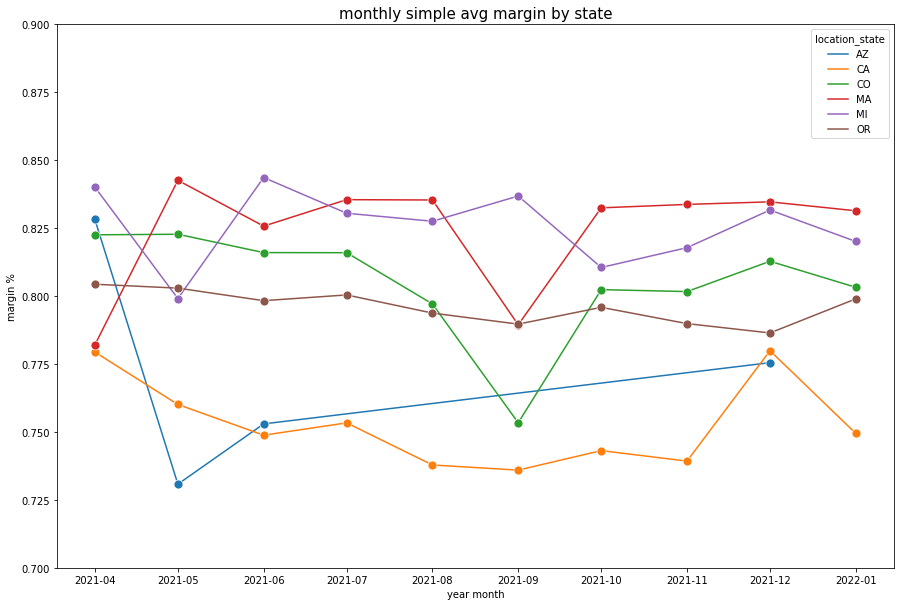

In [21]:
line,ax = plt.subplots(figsize=(15,10))
plt.ylim([0.7, 0.9])
ax.set_title("monthly simple avg margin by state", fontsize=15)
ax.set_xlabel ("year month")
ax.set_ylabel ("margin %")
ax.legend (loc="upper right")


sns.lineplot(data=simple_avg_margin_by_state, x="year_month", y="margin_perc", hue="location_state",marker= 'o', markersize=9)

## weighted average

In [22]:
# assign an column that gives each location's gmv weight in its (month,state)
final_df = final_df.groupby(['year_month','location_state']).apply(lambda df: df.assign(weight=df['NetSales'] / df['NetSales'].sum())).reset_index(drop=True)


In [23]:
weighted_avg_margin_by_state = pd.DataFrame(final_df[['year_month','margin_perc','location_state','weight']].groupby(['location_state','year_month']).apply(lambda x: sum(x['weight']*x['margin_perc'])).reset_index())



In [24]:
weighted_avg_margin_by_state['year_month'] = pd.to_datetime(weighted_avg_margin_by_state['year_month'])
weighted_avg_margin_by_state.columns = ['location_state','year_month','margin_perc']

<AxesSubplot:title={'center':'monthly weighted avg margin by state'}, xlabel='year month', ylabel='margin %'>

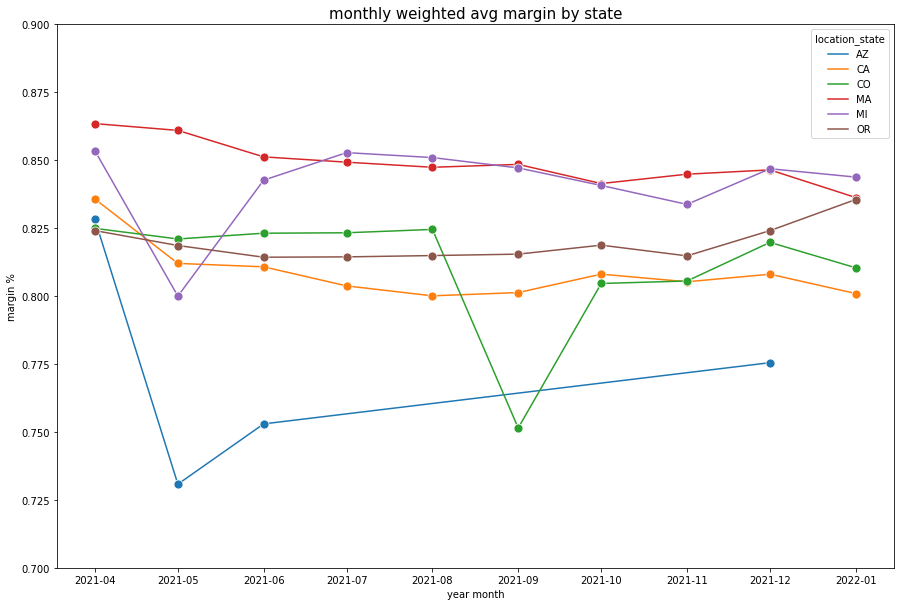

In [25]:
line,ax = plt.subplots(figsize=(15,10))
plt.ylim([0.7, 0.9])
ax.set_title("monthly weighted avg margin by state", fontsize=15)
ax.set_xlabel ("year month")
ax.set_ylabel ("margin %")
ax.legend (loc="upper right")


sns.lineplot(data=weighted_avg_margin_by_state, x="year_month", y="margin_perc", hue="location_state",marker= 'o', markersize=9)

In [27]:
# dip in CO
co = final_df[final_df['location_state'] == 'CO']

In [ ]:

co[['year_month','margin_perc']].groupby(['year_month']).mean().plot()
co[co['margin_perc'] > 0][['year_month','margin_perc']].groupby(['year_month']).mean().plot()

In [ ]:
co.sort_values(by = 'margin_perc')